<h1>Forecasting Electricity Transformer Oil Temperature</h1>

# 1. Data preparation

- Importing all the required libraries for analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller


- Download and Read the dataset file and checking the size of file

In [3]:
!git clone https://github.com/zhouhaoyi/ETDataset.git

Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 187 (delta 66), reused 13 (delta 2), pack-reused 0
Receiving objects: 100% (187/187), 3.85 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [4]:
import pandas as pd 
import matplotlib.pyplot as plt

df1 = pd.read_csv('/content/ETDataset/ETT-small/ETTh1.csv')
#df2 = pd.read_csv('/content/ETDataset/ETT-small/ETTh2.csv')
df1

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


- Visualizing the Time Series 

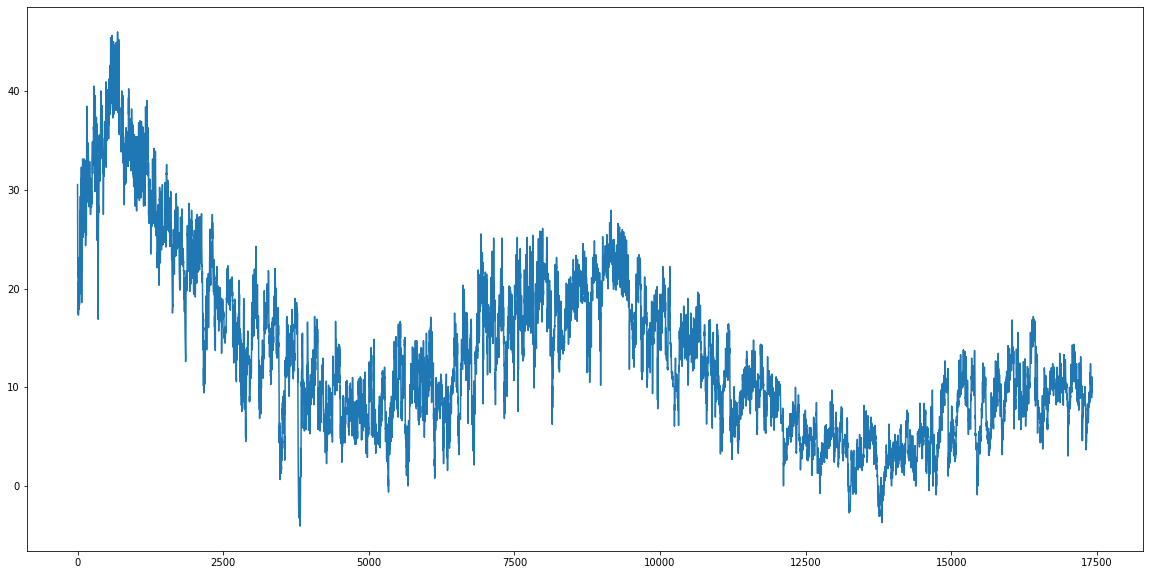

In [5]:
data= df1[['OT',]]
plt.figure(figsize=(20,10))
plt.plot(data)

# 2. Checking stationarity

- As we know that, A stationary Time Series is one which characteristics like mean and variance does not change over time
- Preparing the data for analyzing the Rolling Mean and Standard Deviation to check stationarity for given Time Series

In [ ]:
rolmean=data.rolling(window=7*24).mean()
rolstd=data.rolling(window=7*24).std()
print(rolmean)
print(rolstd)

             OT
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
...         ...
17415  8.112506
17416  8.150607
17417  8.180339
17418  8.198762
17419  8.215512

[17420 rows x 1 columns]
             OT
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
...         ...
17415  1.696084
17416  1.689562
17417  1.682608
17418  1.683059
17419  1.682587

[17420 rows x 1 columns]


- Plotting the Rolling Mean and Standard Deviation, which has window of 12
- By looking below plot, we conclude that, it is non-stationary since mean and variance is not constant

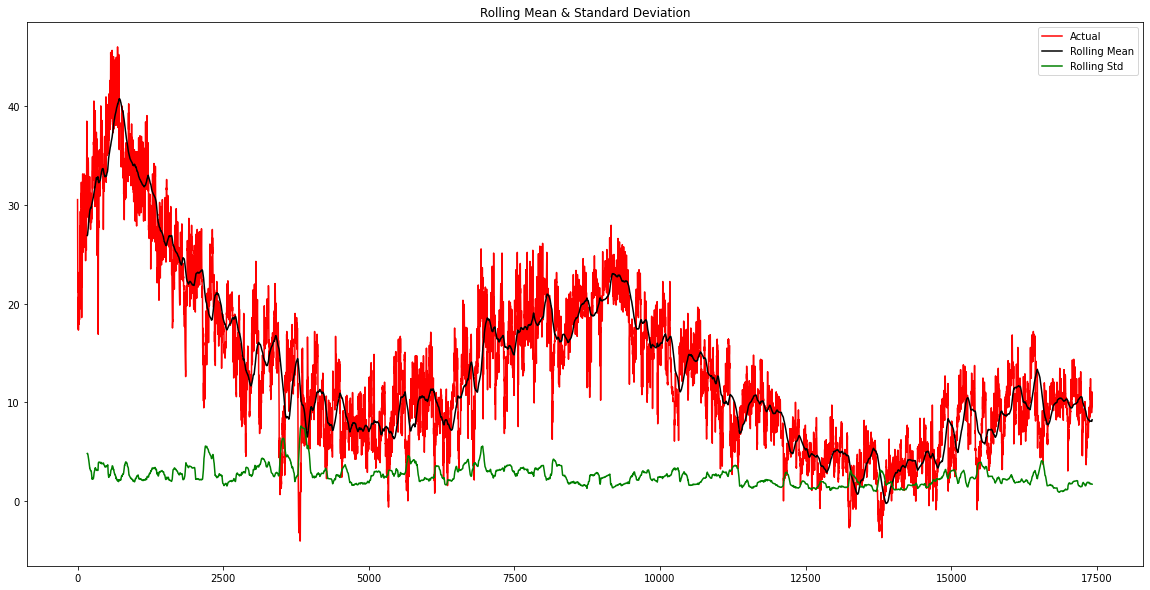

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data, color='red', label='Actual')
plt.plot(rolmean, color='black', label='Rolling Mean') 
plt.plot(rolstd, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

- Using ADF (Augmented Dickey-Fuller Test) to check stationarity, another approach based on statistics.
- ADF has : 
<b>Null hypothesis         - Time Series is non-stationary</b>

In [ ]:
print('Dickey-Fuller Test: ') # details see https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
dftest=adfuller(data['OT'], maxlag = 24*7) 
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic             -2.232280
p-value                     0.194739
Lags Used                 168.000000
No. of Obs              17251.000000
Critical Value (1%)        -3.430729
Critical Value (5%)        -2.861708
Critical Value (10%)       -2.566859
dtype: float64


- From above ADF test, we failed to reject the null hypothesis, since p-value is larger than 0.05.

In fact if we use  adfuller(data, autolag = 'AIC'), we will get wrong conclusion

In [ ]:
adfuller(data.OT, autolag = 'AIC') 

(-3.487963577593396,
 0.008301649485465523,
 44,
 17375,
 {'1%': -3.4307264182079904,
  '10%': -2.566858550311889,
  '5%': -2.8617063622340195},
 45042.46337972503)

# 3. Make data stationary

## create differenced data

In [8]:
data_diff = data.diff(periods=1, axis=0).dropna()

## Defining function for Rolling Mean and Standard Deviation & ADF test

In [ ]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=24*7).mean()
    rolstd=timeseries.rolling(window=24*7).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries.OT, maxlag = 24*7)
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

- Checking the stationarity of differenced data
- From Rolling method, we see that Mean is stablized but standard deviation is still varying.
- From ADF, we can reject the null hypothesis since p-value is  6.360729e-28 (significance level). So the series is stationary

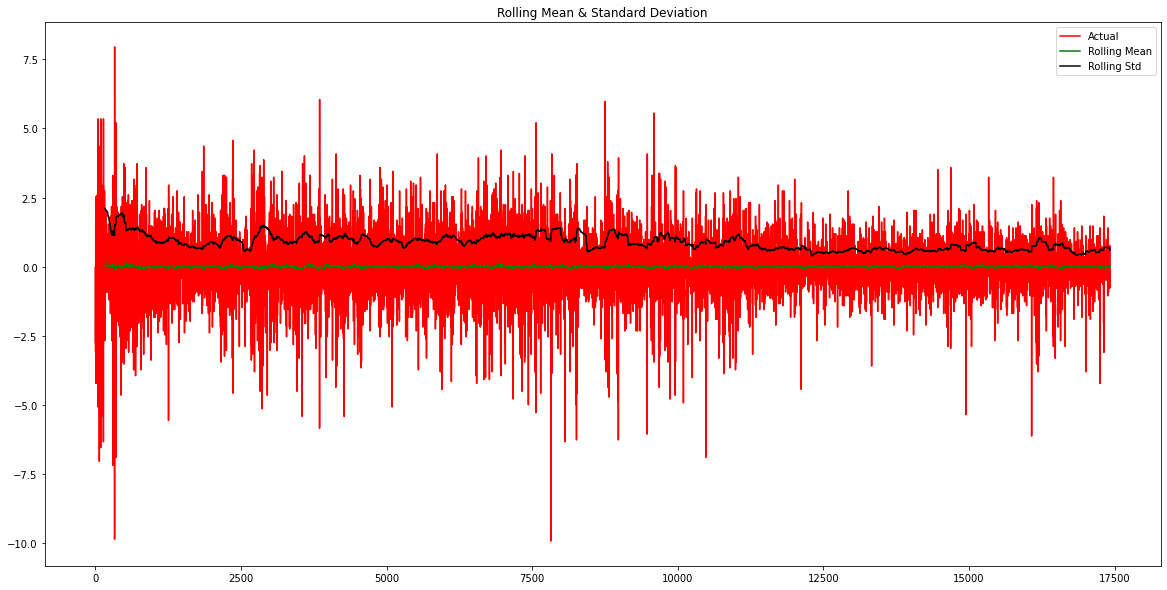

Dickey-Fuller Test: 


KeyboardInterrupt: ignored

In [ ]:
stationarity(data_diff)

## Make data Stationary by log/standardize: not needed for this dataset

- standardize by removing rolling mean

In [ ]:
data_diff = data - data.rolling(12).mean()
data_diff = data_diff.diff(1).dropna()
stationarity(data_diff)

We see it passes the Dickey-Fuller test but still have a diverging variation.

 log transform and standardize by removing rolling mean
- Below we took log transformation to make our Time series stationary and plotted visual for it
- We found graph upward trending over time with seasonality 

In [ ]:
plt.figure(figsize=(20,10))
data_log=np.log(data)
plt.plot(data_log)

- Testing Rolling Mean with window 12 on above log transformation and concluded non-stationary, again

In [ ]:
plt.figure(figsize=(20,10))
MAvg=data_log.rolling(window=12).mean()
MStd=data_log.rolling(window=12).std()
plt.plot(data_log)
plt.plot(MAvg, color='blue', label='Rolling Mean')
plt.plot(MStd, color='black', label='Rolling Std')

### Method 1: Make data stationary  by log and removing moving average

In [ ]:
data_log_diff=data_log-MAvg
data_log_diff=data_log_diff.dropna()
data_log_diff

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
...,...
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230


- Checking the stationarity of differenced data
- From Rolling method, we see that Mean and standard deviation is not varying.
- From ADF, we reject the null hypothesis since p-value is less than 0.05 (significance level). Our differenced data is now stationary

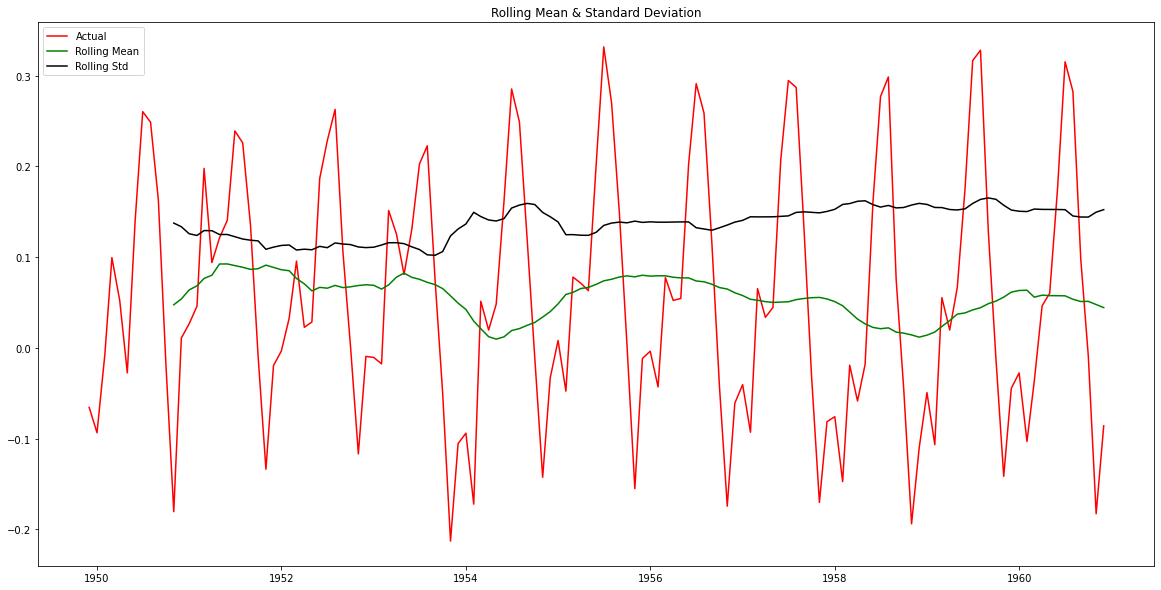

Dickey-Fuller Test: 
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Obs              119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


In [ ]:
stationarity(data_log_diff)

###  Method 2: Make data stationary  by log and removing exponential smoothed trend

- Checking for Trend stationarity and performing exponential smoothing

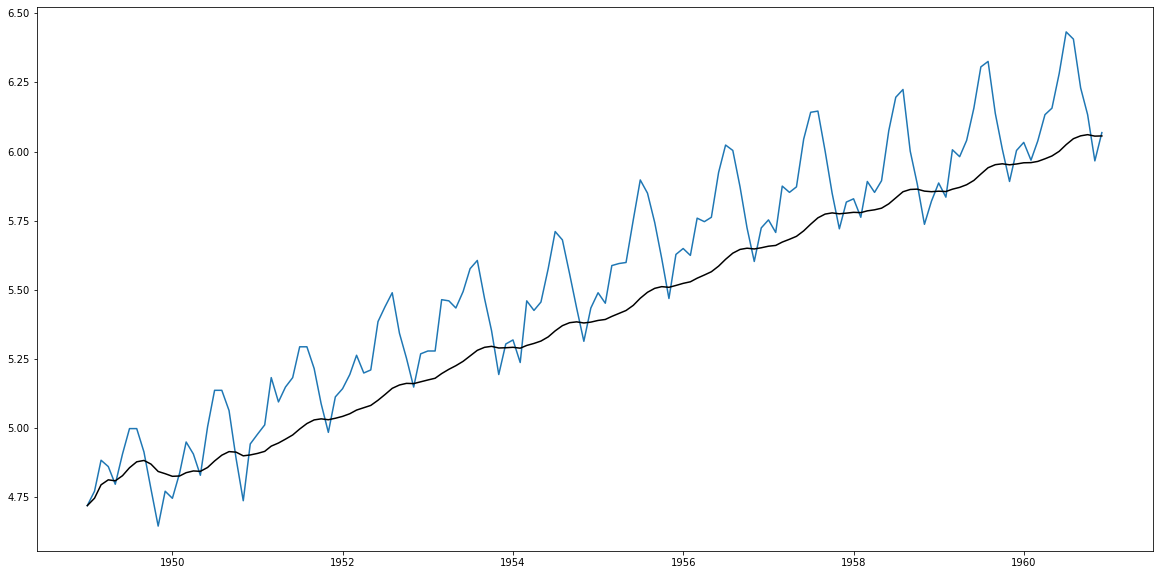

In [ ]:
plt.figure(figsize=(20,10))
expsm_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_log)
plt.plot(expsm_data, color='black')

- Since log transformation is non-stationary, applying differencing on our data.

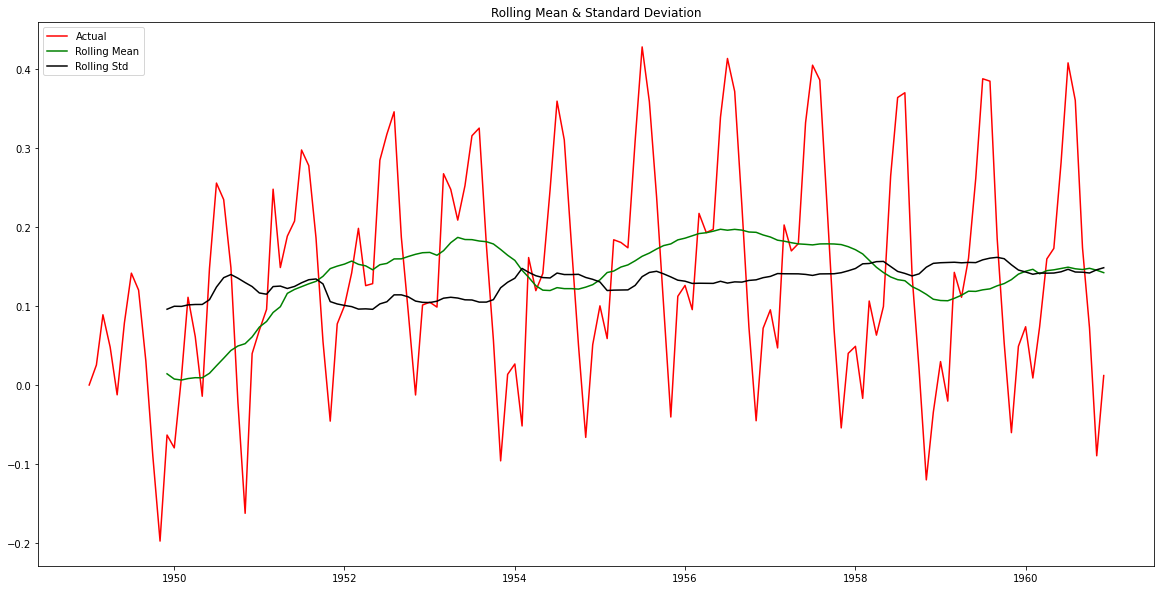

Dickey-Fuller Test: 
Test Statistic           -3.601262
p-value                   0.005737
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [ ]:
expsm_data_diff=data_log-expsm_data
stationarity(expsm_data_diff)

- From above graph and ADF test, we conclude, it is stationary

###  Method 3: Make data stationary  by log and differencing 

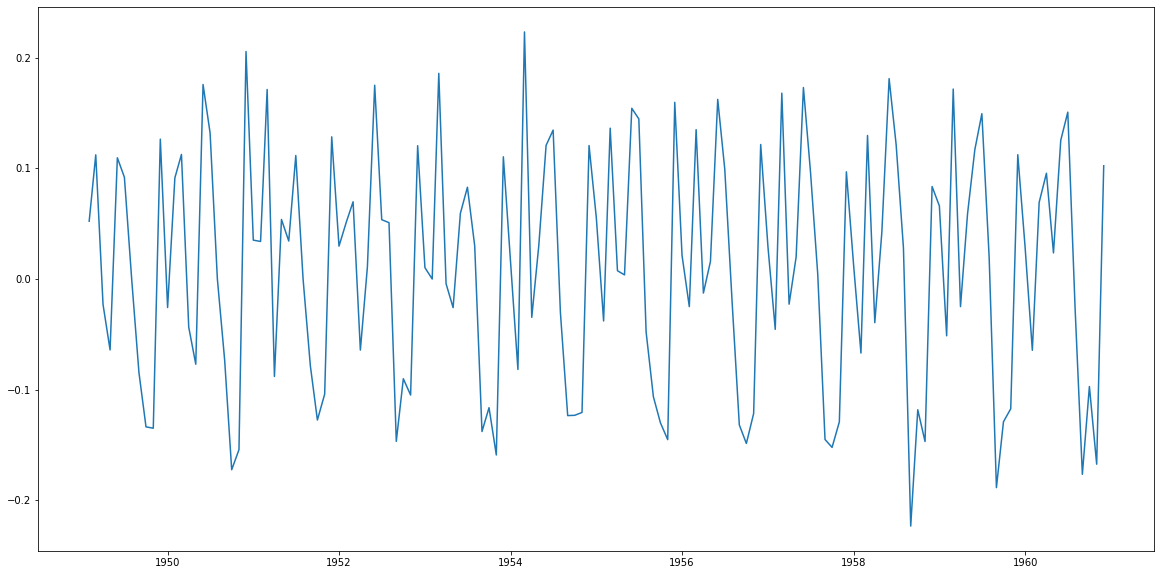

In [ ]:
plt.figure(figsize=(20,10))
data_log_diff = (data_log-data_log.shift()).dropna()
plt.plot(data_log_diff)

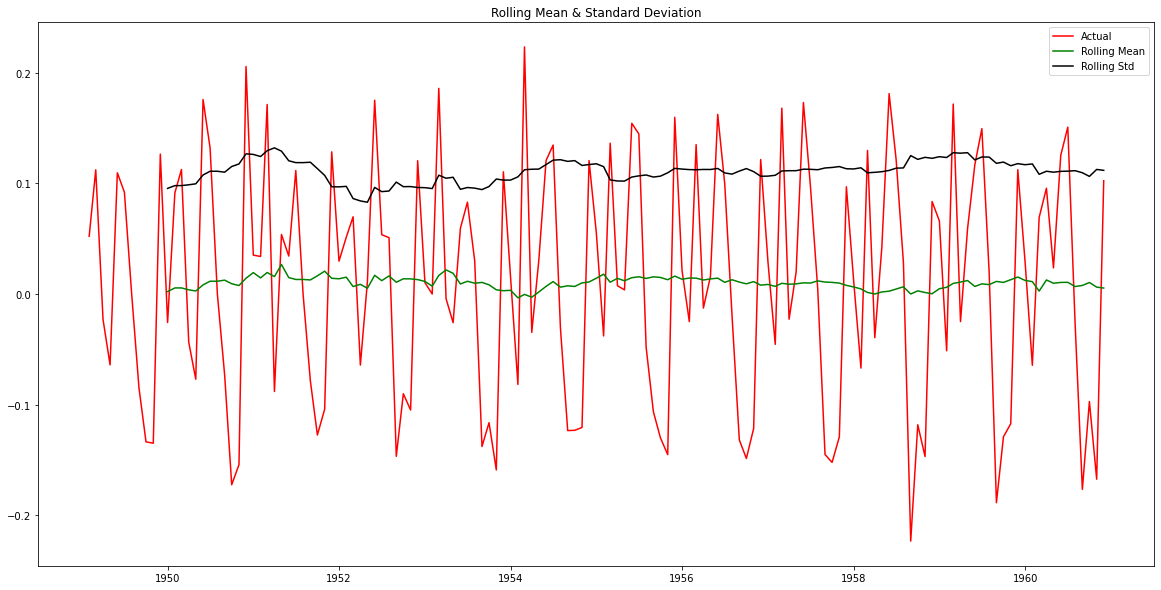

Dickey-Fuller Test: 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Obs              128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [ ]:
stationarity(data_log_diff)

# 4. Arima : using only differencing of order 1

- Decomposing Time Series into its components : Trend, Seasonality and Residual

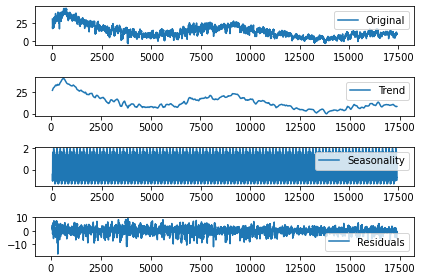

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(data, freq = 24*7)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
data.index

RangeIndex(start=0, stop=17420, step=1)

- Checking the stationarity of Time Series components

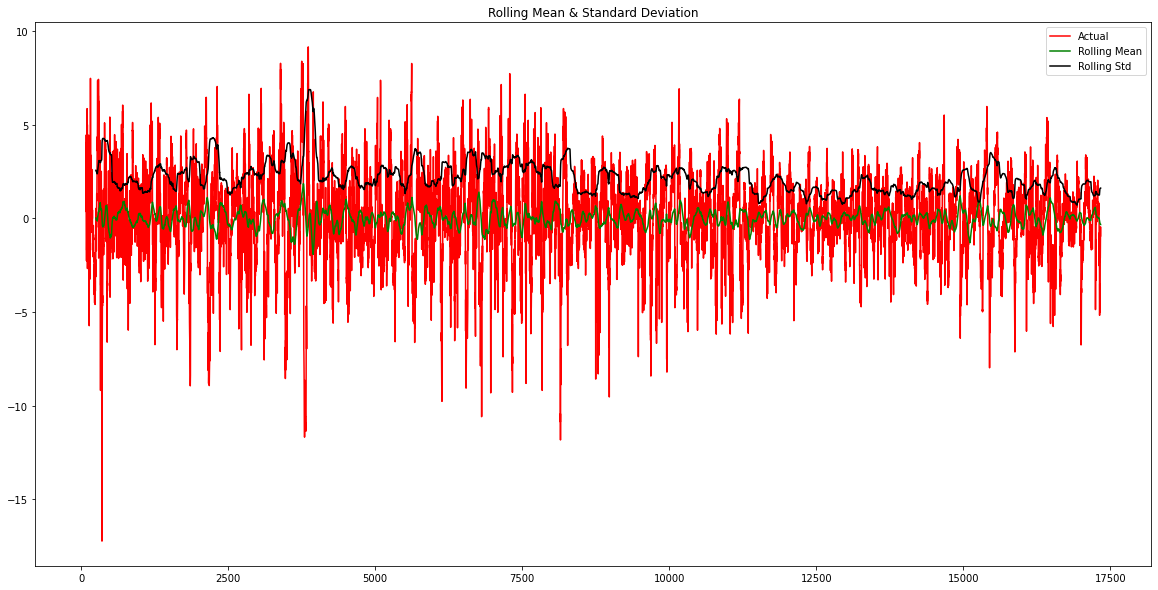

Dickey-Fuller Test: 
Test Statistic         -1.866418e+01
p-value                 2.046675e-30
Lags Used               1.290000e+02
No. of Obs              1.712200e+04
Critical Value (1%)    -3.430732e+00
Critical Value (5%)    -2.861709e+00
Critical Value (10%)   -2.566860e+00
dtype: float64


In [ ]:
decomp_data=residual.dropna()
stationarity(decomp_data)

- Plotting the ACF and PACF to find q and p value
- We got q and p both 24 from the graph

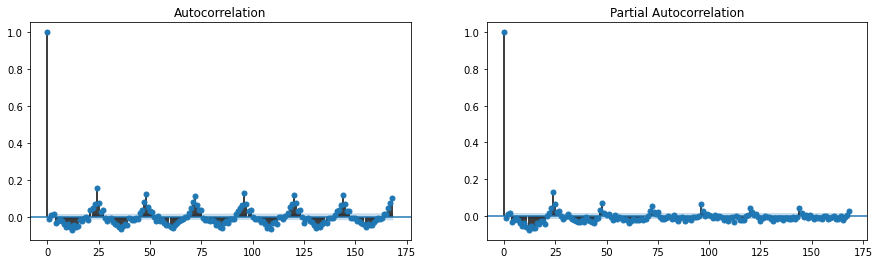

In [ ]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data_diff, lags=24*7, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data_diff, lags=24*7, ax=axes[1])

Text(0.5, 1.0, 'Partial Autocorrelation Function')

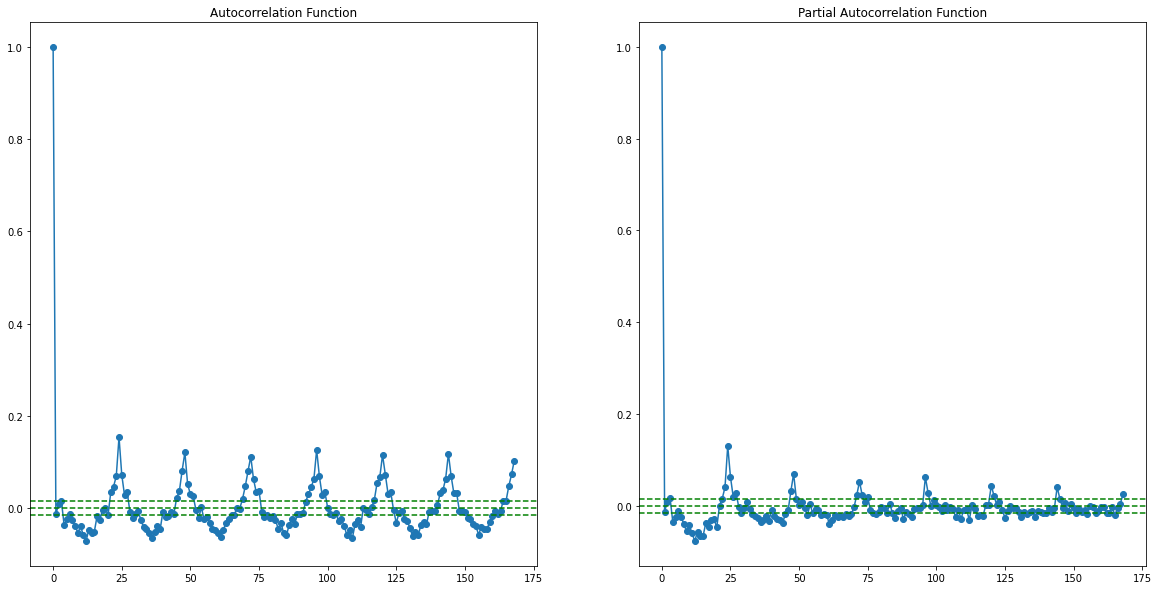

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(data_diff, nlags=24*7)
lag_pacf=pacf(data_diff, nlags=24*7, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf,'o-')
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(data_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf, 'o-')
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(data_diff)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

- Building the ARIMA model with p=2, q=2 and I=1

In [6]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(data[:13000], order=(2,1,2)) 
results=model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.OT   No. Observations:                12999
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -18257.471
Method:                       css-mle   S.D. of innovations              0.986
Date:                Thu, 10 Jun 2021   AIC                          36526.943
Time:                        11:45:10   BIC                          36571.779
Sample:                             1   HQIC                         36541.924
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -1.014      0.311      -0.005       0.002
ar.L1.D.OT     1.6206      0.050     32.624      0.000       1.523       1.718
ar.L2.D.OT    -0.6428      0.047    -13.651      0.0

plotting ARIMA model


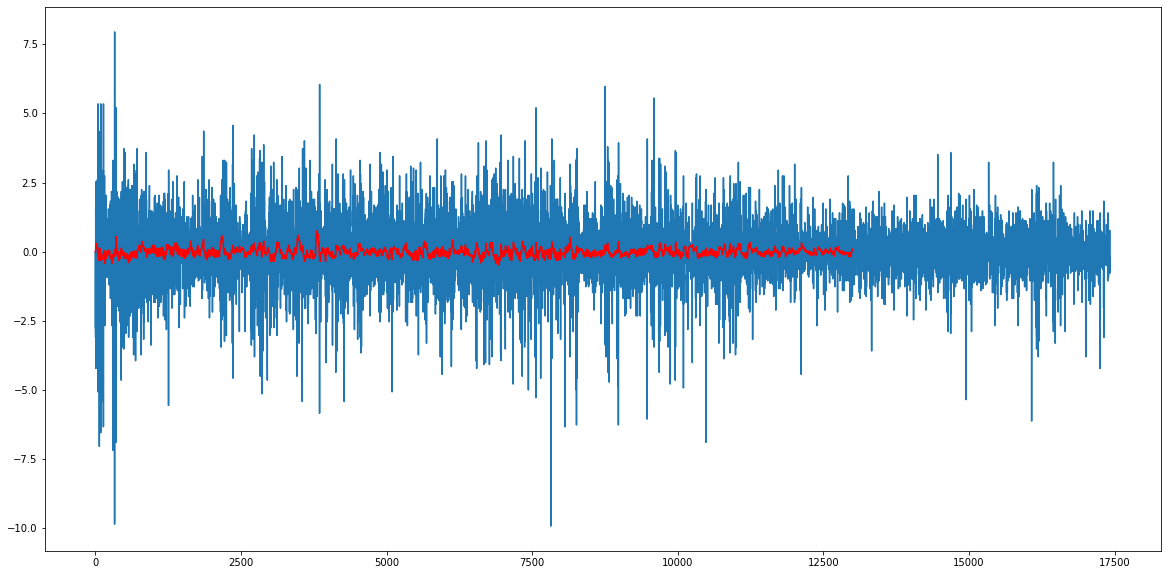

In [9]:

plt.figure(figsize=(20,10))
plt.plot(data_diff)
plt.plot(results.fittedvalues, color='red')
#plt.title('MeanSquare_ReSi: %.4f'% ((results.fittedvalues-data_diff)**2).mean())
print('plotting ARIMA model')

- we make predictions prediction of ARIMA model is in difference form, we convert it back

In [10]:
Fitting = results.predict(start=13000, end=17419, dynamic=True)
print(Fitting)

13000    0.054080
13001    0.055298
13002    0.054812
13003    0.053243
13004    0.051011
           ...   
17415   -0.001707
17416   -0.001707
17417   -0.001707
17418   -0.001707
17419   -0.001707
Length: 4420, dtype: float64


- Performing Inverse Transformation for differencing by adding shifted data to predictions.
- This will give static one-step prediction for the futures. Meaning, we always feed in the previous date data to obtain the current date prediction.

In [11]:
predictions_diff = data.shift().dropna() # shift current day's observation to the next day's
predictions=predictions_diff.add(Fitting, axis=0)

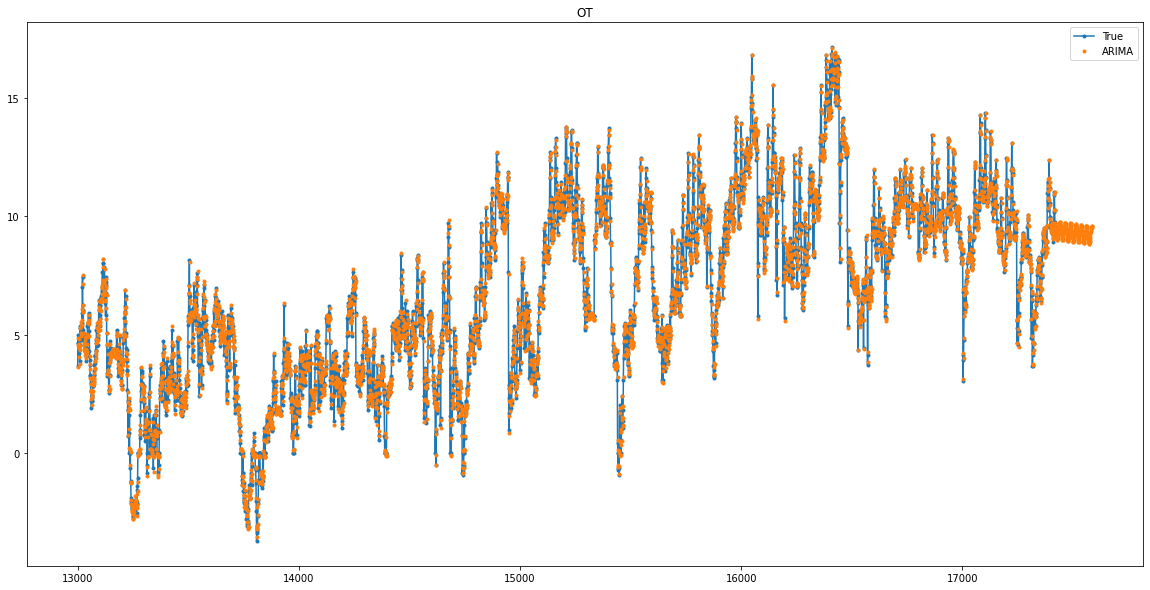

In [21]:
plt.figure(figsize=(20,10))
plt.plot(data[13000:], '.-', label='True')
plt.plot(predictions[13000:], '.', label='ARIMA')
plt.legend(loc='best')
plt.title('OT')
plt.show()

## fit model with full data and Plot future forecast dynamically

- predict the mean forecast

In [13]:
model=ARIMA(data, order=(2,1,2)) # Fit the full data
results=model.fit()

In [14]:
Fitting = pd.DataFrame(results.predict(start=13000, end=17419+24*7, dynamic=True),columns=['OT'])
 
predictions_diff = data.shift().dropna() # shift current day's observation to the next day's
predictions = predictions_diff.add(Fitting, axis=0, fill_value=0)

- out of sample prediction 

In [15]:
predictions[17418:] = predictions[17418:].cumsum()

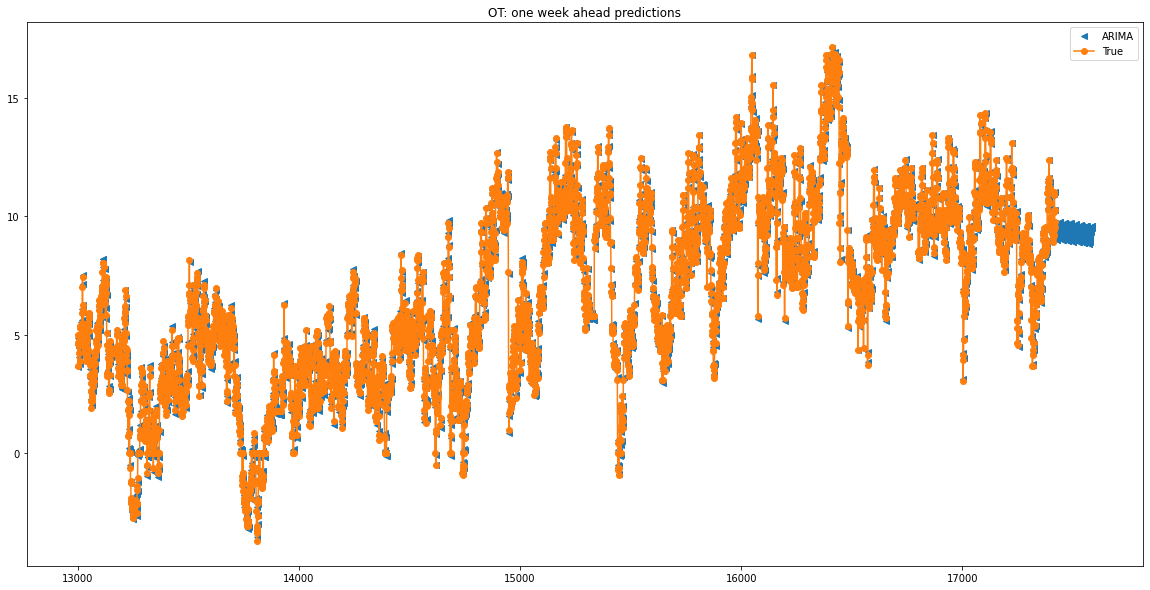

In [17]:
t=  13000 #17200
plt.figure(figsize=(20,10))
plt.plot(predictions[t:], '<', label='ARIMA')
plt.plot(data[t:], 'o-', label='True')
plt.legend(loc='best')
plt.title('OT: one week ahead predictions')
plt.show()

It is bad model since it does not capture any long term seasonality or flutuation.

# 5. Seasonal Arima

## Grid search the p, d, q parameters
- This is skipped since it would take too long to run

In [ ]:
%%time
import itertools
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
%%time
''' 
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,    
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)

'''

Best Result: [(2, 1, 2), (0, 2, 2, 12), 715.1569369855482]

CPU times: user 20min 47s, sys: 1min 33s, total: 22min 20s
Wall time: 20min 22s

## Plot model diagnostics

In [ ]:
%%time
import statsmodels.api as sm
# set up parameters for seasonal Arima 
# run out of ram when sesonal parameters (sp si sq, s)=(0,2,2,24)
best_result = [(1, 1, 1), (1, 0, 0, 24), 715.1569369855482]
mod = sm.tsa.statespace.SARIMAX(data[:13000], 
                                order=(best_result[0][0], best_result[0][1], best_result[0][1]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                #simple_differencing = True,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2528      0.140      1.801      0.072      -0.022       0.528
ma.L1         -0.2893      0.140     -2.073      0.038      -0.563      -0.016
ar.S.L24       0.1652      0.006     27.431      0.000       0.153       0.177
sigma2         0.9607      0.006    164.664      0.000       0.949       0.972
CPU times: user 4.42 s, sys: 540 ms, total: 4.96 s
Wall time: 4.82 s


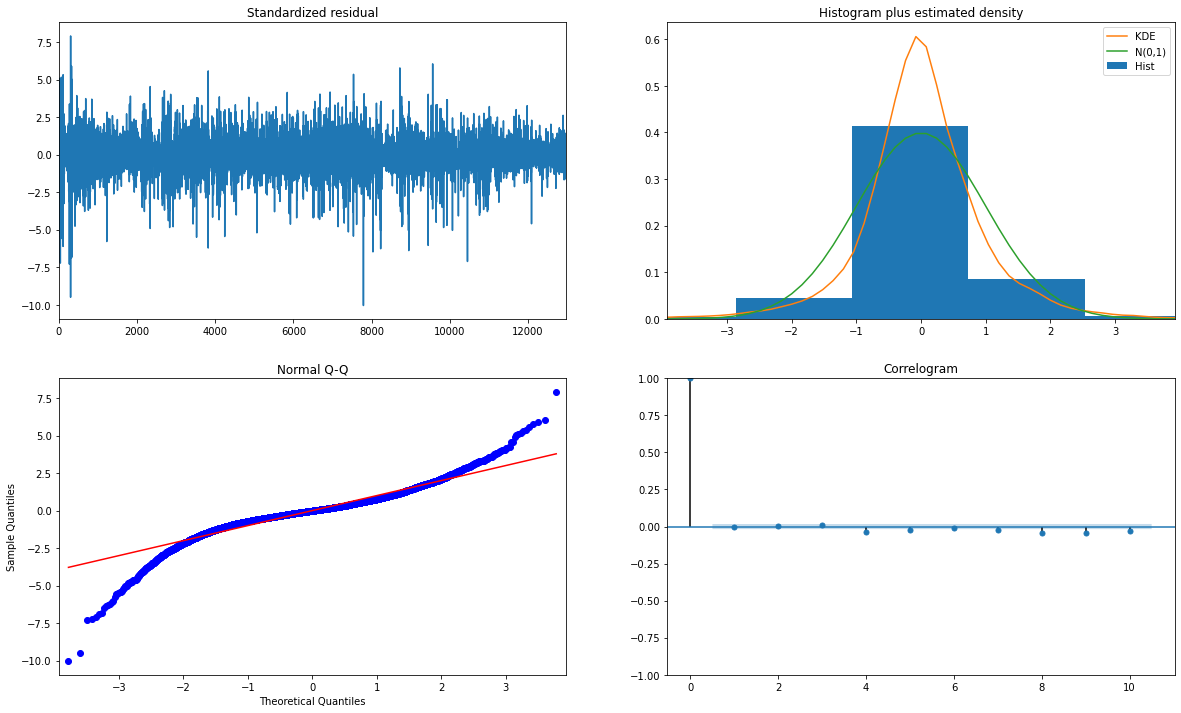

In [ ]:
results.plot_diagnostics(figsize=(20, 12))
plt.show()

## Plot one-step ahead forecast

In [ ]:
pred = results.get_prediction(start=12000, dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
pred.predicted_mean

12000     9.901124
12001     9.596876
12002    10.329644
12003     9.916643
12004     8.182193
           ...    
12995     3.095175
12996     4.470953
12997     2.974878
12998     3.905688
12999     3.913416
Length: 1000, dtype: float64

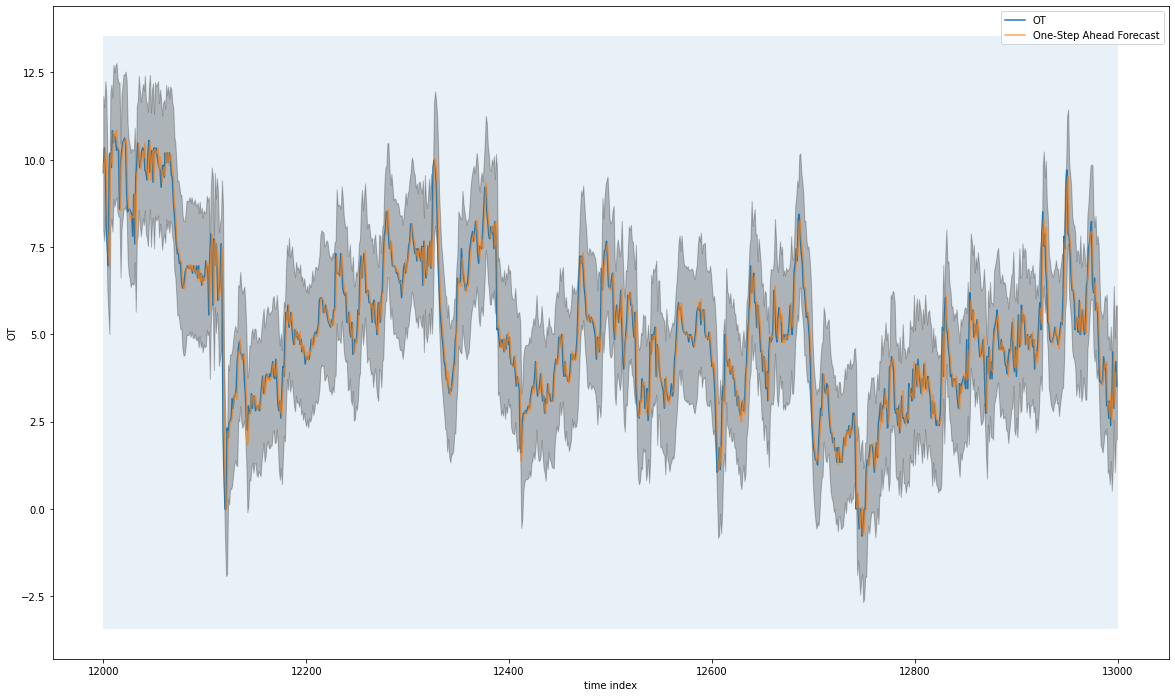

In [ ]:
ax = data[12000:13000].plot(label='Observed', figsize=(20, 12))
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), 12000, 13000,
                 alpha=.1, zorder=-1)

ax.set_xlabel('time index')
ax.set_ylabel('OT')
plt.legend()

plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = data.OT[12000:13000]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.33


## Plot dynamic forecast

One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. 

Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

In [ ]:
pred_dynamic = results.get_prediction(start=12500, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

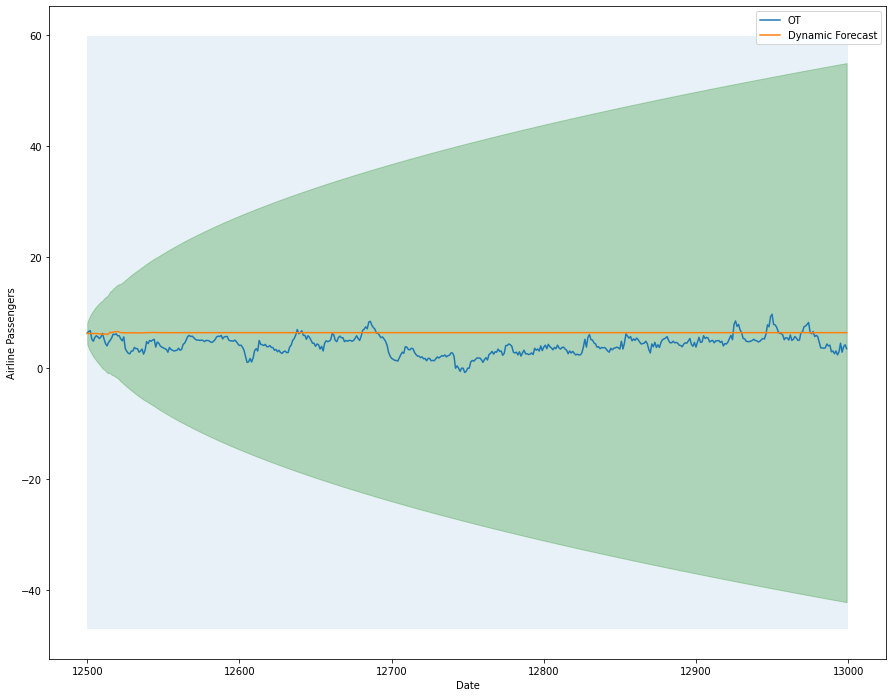

In [ ]:
ax = data[12500:13000].plot(label='Observed', figsize=(15, 12))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='g', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), 12500, 13000,
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('OT')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = data.OT[12500:13000]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 7.43


## Plot one-week forecast

In [ ]:
# Get forecast 24*7 steps ahead in future
pred_uc = results.get_forecast(steps=24*7)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

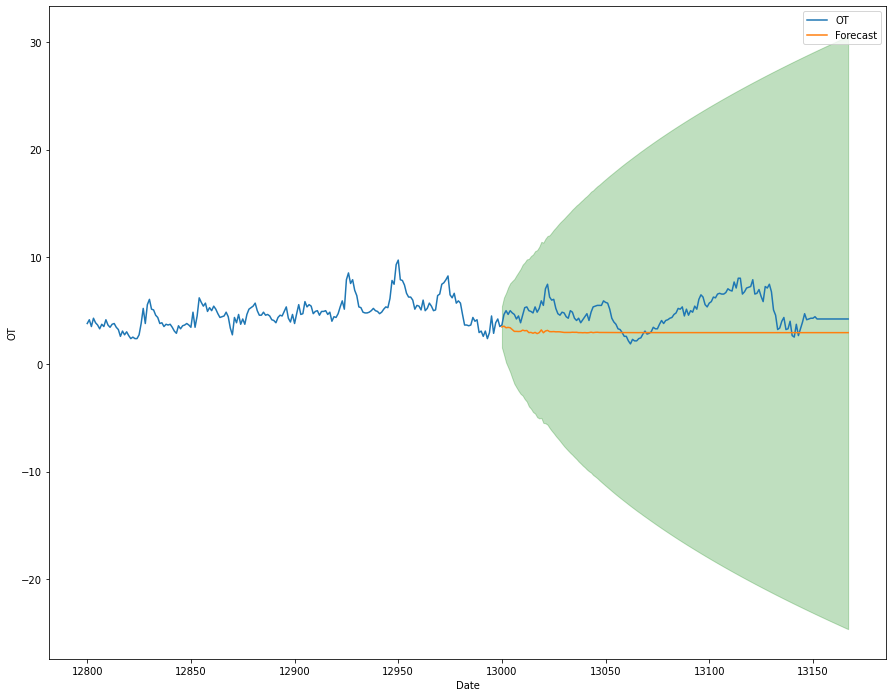

In [ ]:
ax = data[12800:13000+24*7].plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('OT')

plt.legend()
plt.show()

In [ ]:
pred_uc.predicted_mean

13000    3.480770
13001    3.553074
13002    3.402541
13003    3.437569
13004    3.402748
           ...   
13163    2.948464
13164    2.948458
13165    2.948462
13166    2.948463
13167    2.948461
Length: 168, dtype: float64

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = data.OT[13000:13000+24*7]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of One week ahead forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of One week ahead forecasts is 5.24


# Conclusion

With classical time series models, only very limited patterns are captured, such as local seasonality, local trend. These models perform really bad on data with very long dependency. 